# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


<b>Objective:-</b>
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import  MultinomialNB
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import pickle
from tqdm import tqdm
import os

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
sample_data = filtered_data.head(500000) #Sampled amazon fine foood reviews filtered data to 50k datapoints for time effiecieny

# Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=sample_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(sample_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

## Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

3
TITLE: Chicken Soup with Rice<br />AUTHOR: Maurice Sendak<br />REVIEWER: Josh Grossman, Colonel {r}, U.S.A.R., M.C., M.D., FACP<br />Rural physician/author/educator-Mentor U.S.M.L.E. Step 3...<br />>Who would believe that I have memorized this book?<br />>Who would believe that I can recite any month in any order?<br />>Who would believe that I read my copy to tatters while reading to my children now professional adults?<br />>Who would believe that my grandchildren read their copy to tatters?<br />I can be confident that generations of children will enjoy "Chicken Soup with Rice"<br />Bravo!<br />Thank you!<br />Respectfully submitted...


In [12]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"haven't", 'myself', 'shan', "wasn't", 'won', 'ours', 'ain', 'such', 'because', 'no', 'hasn', 'only', 'here', 'more', 'shouldn', 'having', 'over', 'herself', 'being', 'to', 'her', 'by', 'she', 'its', 'each', 'on', 'just', 'who', 'than', 'about', "that'll", "you've", 'if', 'that', 'had', 'be', 'most', 'themselves', 'during', 'few', 'should', 'yours', "needn't", 'are', 'y', 'below', "mightn't", 'do', 'not', "mustn't", 'weren', 'from', 'did', 'the', "doesn't", 'where', 'needn', 'those', 'you', 'didn', 'can', 'mightn', 'were', "you'd", "couldn't", 'but', 'again', 'it', 'me', 've', 'doesn', "isn't", 'yourself', "shan't", 'been', "weren't", 'i', 'was', 'with', 'hadn', 'both', 'and', 'until', "should've", 'd', 'further', "shouldn't", 'into', 'hers', 'don', "you're", 'while', 'above', 't', 'has', 'how', 'own', 'what', 'off', 'whom', 'when', 'nor', 'any', 'my', 'down', 'some', 'haven', 'this', 'before', 'o', 'through', 'ourselves', 'their', 's', 'll', "hasn't", 'in', "you'll", "aren't", 'why',

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8') #snoball stemmer
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f: # 'wb' instead 'w' for binary file
        pickle.dump(all_positive_words, f)      # dump data to f
    with open('negitive_words.pkl', 'wb') as f: # 'wb' instead 'w' for binary file
        pickle.dump(all_negative_words, f)      # dump data to f

In [14]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

### Sorting dataset based on 'Time' feature

In [15]:
final_reviews = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_reviews.shape

(348260, 12)

### Spliting data 

In [16]:
#split data into train, cross validate and test 
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
X = final_reviews['CleanedText']
Y = final_reviews['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0)

In [17]:
print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)

X_train, Y_train (233334,) (233334,)
X_test, Y_test (114926,) (114926,)
X_tr, Y_tr (156333,) (156333,)
X_cv, Y_cv (77001,) (77001,)


# Multinomial Naive Bayes with simple CV

In [18]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

## Training Model

In [19]:
def mulnb(X_train,X_cv,Y_train,Y_cv):
    best_alpha=0
    max_roc_auc=-1
    pred_cv = []
    pred_train = []
    alpha=[10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001] 
    for i in alpha[-19:]:
        mulbnb = MultinomialNB(alpha=i)
        mulbnb.fit(X_train,Y_train)
        probs = mulbnb.predict_proba(X_cv)
        prob = mulbnb.predict_proba(X_train)
        probs = probs[:,1]
        prob = prob[:,1]
        auc_score_cv = roc_auc_score(Y_cv,probs)
        auc_score_train = roc_auc_score(Y_train,prob)
        print(i," ------> ",auc_score_cv)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
        if(max_roc_auc<auc_score_cv):
            max_roc_auc=auc_score_cv
            best_alpha=i
    print(f"\n Best alpha Value {best_alpha} with highest roc_auc Score is {max_roc_auc}")
    sns.set_style("darkgrid")
    plt.xscale('log')
    plt.plot(alpha, pred_cv,'r-', label = 'CV Data')
    plt.plot(alpha,pred_train,'g-', label ='Train Data')
    plt.legend(loc='upper right')
    plt.title(r'Auc Score v/s $\alpha$')
    plt.xlabel(r"alpha values",fontsize=12)
    plt.ylabel("roc_auc",fontsize=12)
    plt.show()
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_cv,probs)
    # plot no skill
    pyplt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplt.plot(fpr, tpr, marker='.')
    #plt.plot(k,pred_cv)
    pyplt.title("Line Plot of ROC Curve on Train Data")
    pyplt.ylabel('True Positive Rate')
    pyplt.xlabel('False Positive Rate')
    pyplt.show()    

## Testing Model 

In [20]:
import scikitplot.metrics as skplt
def testing(X_train,Y_train,X_test,Y_test,optimal_alpha):
    bnb = MultinomialNB(optimal_alpha,fit_prior=True, class_prior=None)
    bnb.fit(X_train,Y_train)
    probs = bnb.predict_proba(X_test) 
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    print("AUC Score",roc_auc_score(Y_test,probs))
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_test,probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("Line Plot of ROC Curve on Test Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show
    prediction=bnb.predict(X_test)
    skplt.plot_confusion_matrix(Y_test,prediction)
    print("macro f1 score for data :",metrics.f1_score(Y_test, prediction, average = 'macro'))
    print("micro f1 scoore for data:",metrics.f1_score(Y_test, prediction, average = 'micro'))
    print("hamming loss for data:",metrics.hamming_loss(Y_test,prediction))
    print("Precision recall report for data:\n",metrics.classification_report(Y_test, prediction))
    

## Top features

In [21]:
def imp_feature(model,classifier):
    neg = classifier.feature_log_prob_[0,:].argsort()
    pos = classifier.feature_log_prob_[1,:].argsort()
    top_pos_words = np.take(model.get_feature_names(),pos)
    top_neg_words = np.take(model.get_feature_names(),neg)
    imp_df = pd.DataFrame(columns = ['Pos_Words','Pos_Importance','Neg_Words','Neg_Importance'])
    imp_df['Pos_Words'] = top_pos_words[::-1]
    imp_df['Pos_Importance'] = np.take(classifier.feature_log_prob_[1,:],pos)[::-1]
    imp_df['Neg_Words'] = top_neg_words[::-1]
    imp_df['Neg_Importance'] = np.take(classifier.feature_log_prob_[0,:],neg)[::-1]
    return imp_df

# Techniques for vectorization :--

##  Bag of Words (BoW) 

In [22]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(bow_train))
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer  (156333, 47172)
CV Data Size:  (77001, 47172)
Test Data Size:  (114926, 47172)


In [23]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
bow_train=preprocessing.normalize(bow_train)
bow_cv=preprocessing.normalize(bow_cv)
bow_test=preprocessing.normalize(bow_test)
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (156333, 47172)
CV Data Size:  (77001, 47172)
Test Data Size:  (114926, 47172)


10000  ------>  0.636370646160004
5000  ------>  0.642259388004025
1000  ------>  0.6612953583871227
500  ------>  0.6696437273597264
100  ------>  0.6916900843222149
50  ------>  0.7073860347835936
10  ------>  0.7850972417666611
5  ------>  0.8389043183678297
1  ------>  0.9227426881602911
0.5  ------>  0.9311163824200236
0.1  ------>  0.9348375799288724
0.05  ------>  0.9345252754760249
0.01  ------>  0.9312802455484984
0.005  ------>  0.9289873138159687
0.001  ------>  0.9221275730861038
0.0005  ------>  0.9186788921536588
0.0001  ------>  0.9100850120932407
5e-05  ------>  0.9062960834324971
1e-05  ------>  0.8976023668853019

 Best alpha Value 0.1 with highest roc_auc Score is 0.9348375799288724


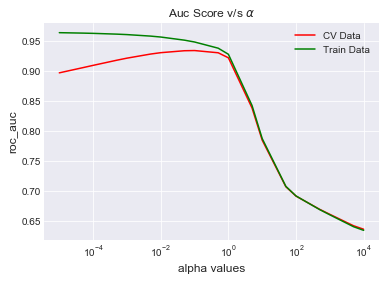

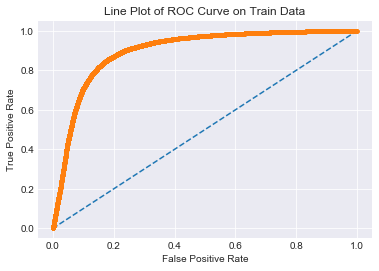

In [24]:
# find optimal alpha 
mulnb(bow_train,bow_cv,Y_tr,Y_cv)

### NB simple CV Over the unseen or Test data in BoW

AUC Score 0.9356708485671656
macro f1 score for data : 0.6150328604181582
micro f1 scoore for data: 0.8686633137845223
hamming loss for data: 0.13133668621547778
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.92      0.18      0.30     18099
           1       0.87      1.00      0.93     96827

   micro avg       0.87      0.87      0.87    114926
   macro avg       0.90      0.59      0.62    114926
weighted avg       0.88      0.87      0.83    114926



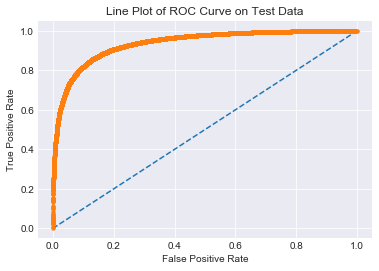

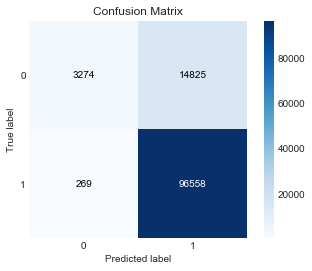

In [25]:
#algorithm = brute force, optimal_k=11
testing(bow_train,Y_tr,bow_test,Y_test,optimal_alpha=0.1)

In [26]:
mnb = MultinomialNB(alpha = 0.1)
mnb.fit(bow_train,Y_tr)
imp_feature(count_vect,mnb)

,Pos_Words,Pos_Importance,Neg_Words,Neg_Importance
0,like,-4.408478,tast,-4.126758
1,tast,-4.412099,like,-4.246824
2,love,-4.433405,product,-4.390704
3,great,-4.458662,one,-4.752713
4,good,-4.476377,flavor,-4.764328
5,flavor,-4.598010,would,-4.856262
6,use,-4.708053,tri,-4.901650
7,product,-4.714912,buy,-5.005655
8,one,-4.797766,good,-5.008839
9,tri,-4.882972,coffe,-5.043479


##  TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (156333, 1700503)
CV Data Size:  (77001, 1700503)
Test Data Size:  (114926, 1700503)


In [28]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
tfidf_train=preprocessing.normalize(tfidf_train)
tfidf_cv=preprocessing.normalize(tfidf_cv)
tfidf_test=preprocessing.normalize(tfidf_test)
print("The shape of out text BOW vectorizer ",tfidf_train.get_shape())
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The shape of out text BOW vectorizer  (156333, 1700503)
CV Data Size:  (77001, 1700503)
Test Data Size:  (114926, 1700503)


10000  ------>  0.6461512740658859
5000  ------>  0.6473422255661663
1000  ------>  0.6541082355075842
500  ------>  0.6594912039398987
100  ------>  0.679685448236734
50  ------>  0.6923646644108793
10  ------>  0.7316951113639796
5  ------>  0.7538849522372294
1  ------>  0.8287088319571705
0.5  ------>  0.8713004566704378
0.1  ------>  0.9375367876517429
0.05  ------>  0.9430939915889895
0.01  ------>  0.9339782961633863
0.005  ------>  0.9249419180950971
0.001  ------>  0.8995744381203381
0.0005  ------>  0.8885836403858436
0.0001  ------>  0.8654511661583819
5e-05  ------>  0.8567242961986493
1e-05  ------>  0.8391959259654784

 Best alpha Value 0.05 with highest roc_auc Score is 0.9430939915889895


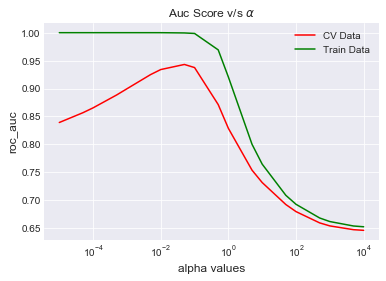

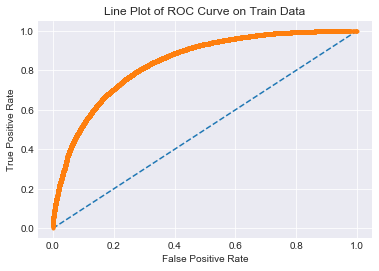

In [29]:
# find optimal_alpha
mulnb(tfidf_train,tfidf_cv,Y_tr,Y_cv)

### KNN with simple CV Over the unseen or Test data in TF-IDF

AUC Score 0.9443887916254162
macro f1 score for data : 0.7134150287115463
micro f1 scoore for data: 0.8906078694116215
hamming loss for data: 0.10939213058837861
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.93      0.33      0.49     18099
           1       0.89      1.00      0.94     96827

   micro avg       0.89      0.89      0.89    114926
   macro avg       0.91      0.66      0.71    114926
weighted avg       0.89      0.89      0.87    114926



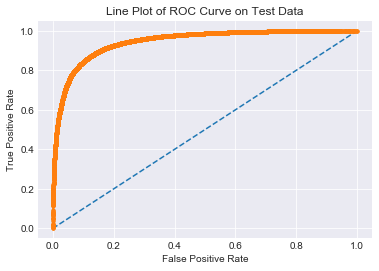

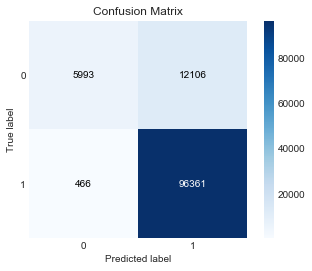

In [30]:
testing(tfidf_train,Y_tr,tfidf_test,Y_test,optimal_alpha=0.05)

In [31]:
mnb = MultinomialNB(alpha = 0.05)
mnb.fit(tfidf_train,Y_tr)
imp_feature(tf_idf_vect,mnb)

,Pos_Words,Pos_Importance,Neg_Words,Neg_Importance
0,great,-6.297653,tast,-6.357245
1,love,-6.299114,like,-6.490941
2,tast,-6.341551,product,-6.514279
3,like,-6.351108,would,-6.837367
4,good,-6.353745,coffe,-6.854715
5,tea,-6.395088,flavor,-6.874824
6,flavor,-6.409692,one,-6.879084
7,coffe,-6.422050,order,-6.990328
8,use,-6.512606,buy,-6.993840
9,product,-6.530451,tri,-6.994613


In [32]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Best hyper parameter($\alpha$)","Test Auc Score"]
x.add_row(["BoW","MultinomialNB",0.1,93.56])
x.add_row(["Tf-Idf","MultinomialNB",0.05,94.43])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)

****Final Conclusion:****

+------------+---------------+-------------------------------+----------------+
| Vectorizer |     Model     | Best hyper parameter($lpha$) | Test Auc Score |
+------------+---------------+-------------------------------+----------------+
|    BoW     | MultinomialNB |              0.1              |     93.56      |
|   Tf-Idf   | MultinomialNB |              0.05             |     94.43      |
+------------+---------------+-------------------------------+----------------+
